Modified based on [1] to understand the data generating process. 

References: 

- [1] Ye, J., & Pandarinath, C. (2021). Representation learning for neural population activity with Neural Data Transformers. In arXiv [q-bio.NC]. arXiv. http://arxiv.org/abs/2108.01210
    - Code: https://github.com/snel-repo/neural-data-transformers  

In [1]:
#!/usr/bin/env python3
# Author: Joel Ye

r""" Notebook for generating Lorenz attractor data.
Note:
    This is an example reference,
    and does not reproduce the data with repeated conditions used in the paper.
    That was generated with LFADS utilities, which we are unable to release at this time.
"""

#%%
import os
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import torch
import torch.nn as nn
from torch.distributions import Poisson
torch.set_grad_enabled(False)

default_s = 10 # sigma
default_r = 28 # rho
default_b = 2.667 # beta

In [2]:
def lorenz_deriv(x, y, z, s=default_s, r=default_r, b=default_b):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

def lorenz_generator(
        initial_values,
        s=default_s, r=default_r, b=default_b,
        dt=0.01, num_steps=10000
    ):
    TRANSIENT_TIME = 50 # dock this
    values = np.empty((3, num_steps + TRANSIENT_TIME + 1))
    values[:, 0] = np.array(initial_values)
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps + TRANSIENT_TIME):
        x_dot, y_dot, z_dot = lorenz_deriv(
            values[0, i],
            values[1, i],
            values[2, i],
            s, r, b
        )
        values[0, i + 1] = values[0, i] + (x_dot * dt)
        values[1, i + 1] = values[1, i] + (y_dot * dt)
        values[2, i + 1] = values[2, i] + (z_dot * dt)
    return values.T[TRANSIENT_TIME:]

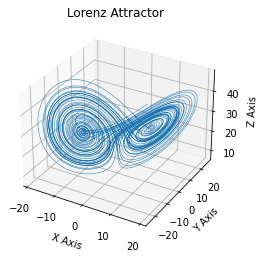

In [3]:
#%%
initial_values = (0., 1., 1.05)
lorenz_data = lorenz_generator(initial_values, num_steps=5000).T
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(*lorenz_data, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [4]:
# Data HPs
seed = 0
np.random.seed(seed)
n = 2000
t = 200
initial_values = np.random.random((n, 3))
lorenz_params = np.array([default_s, default_r, default_b]) \
    + np.random.random((n, 3)) * 10 # Don't deviate too far from chaotic params

# Generate data
lorenz_dataset = np.empty((n, t, 3))
for i in range(n):
    s, r, b = lorenz_params[i]
    lorenz_dataset[i] = lorenz_generator(
        initial_values[i], s=s, r=r, b=b,
        num_steps=t # Other values tend to be bad
    )[1:] # Drops initial value

noise = np.random.random((n, t, 3)) * 0 # No noise

trial_min = lorenz_dataset.min(axis=1)
trial_max = lorenz_dataset.max(axis=1)
lorenz_dataset -= trial_min[:, None, :]
lorenz_dataset /= trial_max[:, None, :]
lorenz_dataset += noise

In [5]:
#%%
torch.manual_seed(seed)
# Convert factors to spike times
n_neurons = 30
SPARSE = True
# What. How do we get this to look normal
def lorenz_rates_to_rates_and_spike_times(dataset, base=0, dynamic_range=(-2, 2)):
    # lorenz b x t x 3 -> b x t x h (h neurons)
    linear_transform = nn.Linear(3, n_neurons) # Generates a random transform
    linear_transform.weight.data.uniform_(*dynamic_range)
    # base = torch.log(torch.tensor(base) / 1000.0)
    linear_transform.bias.data.fill_(base)
    raw_logrates = linear_transform(torch.tensor(dataset).float())
    if SPARSE:
        # raw_logrates /= raw_logrates.max() # make max firing lograte 0.5 ~ 1.65 firing rate
        clipped_logrates = torch.clamp(raw_logrates, -10, 1) # Double take
    else:
        clipped_logrates = torch.clamp(raw_logrates, 0, 20) # Double take
    # Leads to spikes mostly in 1-5
    neuron_rates = torch.exp(clipped_logrates)
    return Poisson(neuron_rates).sample(), clipped_logrates

# default mean firing rate is 5
spike_timings, logrates = lorenz_rates_to_rates_and_spike_times(lorenz_dataset)



tensor(1.0762)


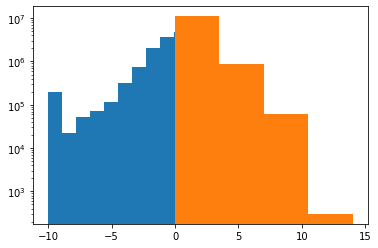

In [6]:

# sns.heatmap(spike_timings[0])
# sns.heatmap(logrates[0,:,:])


print(torch.exp(logrates).mean())
# plt.hist(torch.exp(logrates.flatten()).numpy())
plt.hist(logrates.flatten().numpy())

if SPARSE:
    plt.yscale("log")
    plt.hist(spike_timings.flatten().numpy(), bins=4)
# %%
# 2000
train_n = 160
val_n = int((n - train_n) / 2)
test_n = int((n - train_n) / 2)
splits = (train_n, val_n, test_n)
assert sum(splits) <= n, "Not enough data trials"

train_rates, val_rates, test_rates = torch.split(logrates, splits)
train_spikes, val_spikes, test_spikes = \
    torch.split(spike_timings, splits)


def pack_dataset(rates, spikes):
    return {
        "rates": rates,
        "spikes": spikes.long()
    }

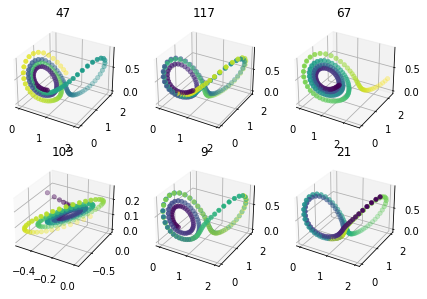

Train 	 1.0
Val 	 1.0


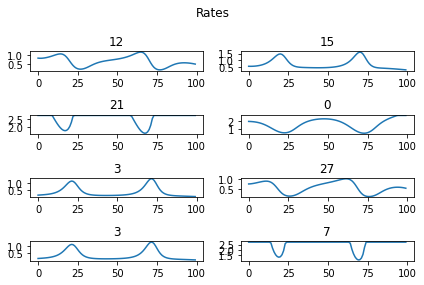

Train 	 9.0
Val 	 10.0


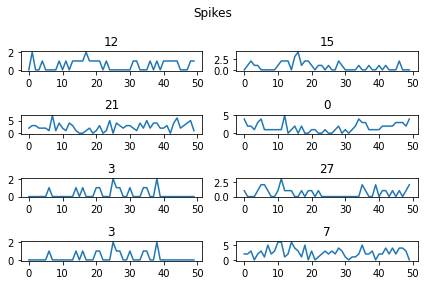

In [7]:
#%%
# Plot trajectories
np.random.seed(0)
fig = plt.figure()
NUM_PLOTS = 6
for i in range(NUM_PLOTS):
    sample_idx = np.random.randint(0, train_n)
    sample = lorenz_dataset[sample_idx].T
    ax = fig.add_subplot(231 + i, projection='3d')
    color = np.linspace(0, 1, sample.shape[1])
    ax.scatter(*sample, lw=0.5, c=color)

    ax.set_title(f"{sample_idx}")
fig.tight_layout()

plt.show()

#%%
# Plot rates
np.random.seed(0)
fig = plt.figure()
NUM_PLOTS = 8
print(f"Train \t {train_rates[0].max().item()}")
print(f"Val \t {val_rates[0].max().item()}")
plot_t = 100
for i in range(NUM_PLOTS):
    sample_idx = np.random.randint(0, n_neurons)
    sample = torch.exp(train_rates[0, :plot_t, sample_idx]).numpy()
    ax = fig.add_subplot(421 + i)
    ax.plot(np.arange(plot_t), sample, )
    # ax.scatter(np.arange(t), sample, c=np.arange(0, 1, 1.0/t))

    ax.set_title(f"{sample_idx}")
plt.suptitle("Rates")
fig.tight_layout()
plt.show()

#%%
# Plot spike times
np.random.seed(0)
fig = plt.figure()
NUM_PLOTS = 8
print(f"Train \t {train_spikes[0].max().item()}")
print(f"Val \t {val_spikes[0].max().item()}")
plot_t = 50
for i in range(NUM_PLOTS):
    sample_idx = np.random.randint(0, n_neurons)
    plot_data = train_spikes[0, :plot_t, sample_idx]
    sample = plot_data.numpy()
    ax = fig.add_subplot(421 + i)
    ax.plot(np.arange(plot_t), sample, )
    # ax.scatter(np.arange(t), sample, c=np.arange(0, 1, 1.0/t))

    ax.set_title(f"{sample_idx}")
plt.suptitle("Spikes")
fig.tight_layout()
plt.show()